In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import re
import importlib
# Load the questionnaire data
questionnaire_df = pd.read_excel('data/questionnaire_data-561422-2025-11-17-1240.xlsx')

/home/michaelt/.cache/pypoetry/virtualenvs/in9060-as2-Pf7P2CoS-py3.12/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [2]:
# Rename questionnaire_df columns to concise snake_case with condition suffixes


# Mapping from full question text to short code
_base_map = {
    'Participant number': 'participant_id',
    'What is your gender': 'gender',
    'How old are you?': 'age',
    'What is your dominant hand?': 'dominant_hand',
    'How experienced are you with robotic systems?': 'robotics_experience',
    'Did you experience delays between your actions and the robot\'s movements?': 'delay',
    'How difficult was it to perform the task?': 'difficulty',
    'I felt like I was controlling the movement of the robot': 'control',
    'It felt like the robot was part of my body': 'body'
}

repeating_keys = {'delay','difficulty','control','body'}
rename_map = {}
for col in questionnaire_df.columns:
    if col.startswith('$'):  # keep metadata columns unchanged
        continue
    # Remove HTML entity artifacts
    col_clean = col.replace('&#39;', "'")
    # Extract suffix like .1, .2, etc.
    m = re.search(r'\.(\d+)$', col_clean)
    base = re.sub(r'\.(\d+)$', '', col_clean)
    short = _base_map.get(base, None)
    if short is None:
        # If unknown and not metadata, create a generic snake_case key
        generic = re.sub(r'[^A-Za-z0-9]+', '_', base).strip('_').lower()
        short = generic or base.lower()
    if m:
        suffix = f"_{m.group(1)}"  # condition index from original numbering
    elif short in repeating_keys:
        suffix = "_0"  # first occurrence without explicit suffix
    else:
        suffix = ""
    rename_map[col] = short + suffix

questionnaire_df = questionnaire_df.rename(columns=rename_map)

print('Renamed columns (first 25):')
print(list(questionnaire_df.columns)[:25])

# Filter out columns containing "$"
filtered_columns = [col for col in questionnaire_df.columns if '$' not in col and col != 'Participant number']
print('Filtered columns (first 25):')
print(filtered_columns[:25])

participant_data_columns = filtered_columns[0:4]
task_one_columns = filtered_columns[5:25]
task_two_columns = filtered_columns[25:]

participant_df = questionnaire_df[participant_data_columns]
task_one_df = questionnaire_df[task_one_columns]
task_two_df = questionnaire_df[task_two_columns]
all_tasks_df = task_one_df + task_two_df

print('Filtered columns (first 25):')
print(list(task_one_df.columns)[:25])

metric_mask_delay = [col for col in all_tasks_df.columns if col.startswith('delay_')]
metric_mask_difficulty = [col for col in all_tasks_df.columns if col.startswith('difficulty_')]
metric_mask_control = [col for col in all_tasks_df.columns if col.startswith('control_')]
metric_mask_body = [col for col in all_tasks_df.columns if col.startswith('body_')]

# Filter task_one_df for male participants
male_mask = participant_df['gender'] == 'Male'
female_mask = participant_df['gender'] == 'Female'
Other_mask = participant_df['gender'] == 'Other'
task_one_male_df = task_one_df[male_mask]
task_one_female_df = task_one_df[female_mask]

# Age mask and arrays
# Calculate median age
median_age = participant_df['age'].median()
age_mask_A24 = participant_df['age'] > median_age
age_mask_U24 = participant_df['age'] <= median_age

# Select from task_one_df where both male_mask and age_mask_A24 are true
task_one_M_A24 = task_one_df[male_mask & age_mask_A24]
task_one_M_U24 = task_one_df[male_mask & age_mask_U24]
task_one_F_A24 = task_one_df[female_mask & age_mask_A24]
task_one_F_U24 = task_one_df[female_mask & age_mask_U24]


Renamed columns (first 25):
['$submission_id', '$created', 'participant_id', 'gender', 'age', 'dominant_hand', 'robotics_experience', 'delay_0', 'difficulty_0', 'control_0', 'body_0', 'delay_1', 'difficulty_1', 'control_1', 'body_1', 'delay_2', 'difficulty_2', 'control_2', 'body_2', 'delay_3', 'difficulty_3', 'control_3', 'body_3', 'delay_4', 'difficulty_4']
Filtered columns (first 25):
['participant_id', 'gender', 'age', 'dominant_hand', 'robotics_experience', 'delay_0', 'difficulty_0', 'control_0', 'body_0', 'delay_1', 'difficulty_1', 'control_1', 'body_1', 'delay_2', 'difficulty_2', 'control_2', 'body_2', 'delay_3', 'difficulty_3', 'control_3', 'body_3', 'delay_4', 'difficulty_4', 'control_4', 'body_4']
Filtered columns (first 25):
['delay_0', 'difficulty_0', 'control_0', 'body_0', 'delay_1', 'difficulty_1', 'control_1', 'body_1', 'delay_2', 'difficulty_2', 'control_2', 'body_2', 'delay_3', 'difficulty_3', 'control_3', 'body_3', 'delay_4', 'difficulty_4', 'control_4', 'body_4']


In [3]:
# Difficulty for Male-Female
task_one_difficulty_df = task_one_df[[col for col in task_one_df.columns if col.startswith('difficulty_')]]
task_one_difficulty_df_male = task_one_difficulty_df[male_mask]
task_one_difficulty_df_female = task_one_difficulty_df[female_mask]

task_one_stats_male = pd.DataFrame({
    'Mean': task_one_difficulty_df_male.mean(numeric_only=True),
    'Variance': task_one_difficulty_df_male.var(numeric_only=True)
})
task_one_stats_female = pd.DataFrame({
    'Mean': task_one_difficulty_df_female.mean(numeric_only=True),
    'Variance': task_one_difficulty_df_female.var(numeric_only=True)
})

print("Task One Statistics Male:")
print(task_one_stats_male)
print("\nTask One Statistics Female:")
print(task_one_stats_female)

Task One Statistics Male:
                  Mean  Variance
difficulty_0  2.958333  0.737319
difficulty_1  2.333333  1.014493
difficulty_2  2.416667  0.775362
difficulty_3  2.333333  1.362319
difficulty_4  2.458333  1.128623

Task One Statistics Female:
              Mean  Variance
difficulty_0   2.8  0.844444
difficulty_1   2.6  0.933333
difficulty_2   2.7  0.900000
difficulty_3   2.4  0.488889
difficulty_4   2.6  0.488889


In [4]:
# Difficulty for MF and Age 
task_one_difficulty_df = task_one_df[[col for col in task_one_df.columns if col.startswith('difficulty_')]]
task_one_difficulty_df_male = task_one_difficulty_df[male_mask]
task_one_difficulty_df_female = task_one_difficulty_df[female_mask]

task_one_difficulty_M_A24 = task_one_difficulty_df[male_mask & age_mask_A24]
task_one_difficulty_M_U24 = task_one_difficulty_df[male_mask & age_mask_U24]
task_one_difficulty_F_A24 = task_one_difficulty_df[female_mask & age_mask_A24]
task_one_difficulty_F_U24 = task_one_difficulty_df[female_mask & age_mask_U24]

task_one_stats_male_A24 = pd.DataFrame({
    'Mean': task_one_difficulty_M_A24.mean(numeric_only=True),
    'Variance': task_one_difficulty_M_A24.var(numeric_only=True)
})
task_one_stats_female_A24 = pd.DataFrame({
    'Mean': task_one_difficulty_F_A24.mean(numeric_only=True),
    'Variance': task_one_difficulty_F_A24.var(numeric_only=True)
})
task_one_stats_male_U24 = pd.DataFrame({
    'Mean': task_one_difficulty_M_U24.mean(numeric_only=True),
    'Variance': task_one_difficulty_M_U24.var(numeric_only=True)
})
task_one_stats_female_U24 = pd.DataFrame({
    'Mean': task_one_difficulty_F_U24.mean(numeric_only=True),
    'Variance': task_one_difficulty_F_U24.var(numeric_only=True)
})

print("Task One Statistics Male:")
print(task_one_stats_male_A24)
print("\nTask One Statistics Female:")
print(task_one_stats_female_A24)

Task One Statistics Male:
              Mean  Variance
difficulty_0   3.4       0.3
difficulty_1   2.8       0.7
difficulty_2   2.6       0.3
difficulty_3   2.6       1.3
difficulty_4   2.6       0.8

Task One Statistics Female:
                  Mean  Variance
difficulty_0  2.500000  0.700000
difficulty_1  2.166667  0.566667
difficulty_2  3.166667  0.566667
difficulty_3  2.333333  0.666667
difficulty_4  2.666667  0.666667


In [5]:
task_one_difficulty_df_male.shape[0]
task_one_difficulty_df_male.shape[1]

5

In [6]:
# Basic Single iteration

import alt_statistics as alt_vp
# importlib.reload(alt_vp)
all_variance_stats = alt_vp.calculate_statistics(
    distributions=[
        # task_one_difficulty_df_male["difficulty_0"], task_one_difficulty_df_female["difficulty_0"]
        task_one_difficulty_df_male, task_one_difficulty_df_female
    ],
    group_labels=['Male', 'Female'],
    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
    variance_types=['sample', 'population','alt_ssa', 'alt_ftest'],
    # variance_types=['sample', 'mse', 'tukey', 'sst', 'sse', 'ssa', 'ftest'],
    # output_csv='comprehensive_stats_delay_overall.csv'
    output_csv='out_csv/difficulty MF/comprehensive_stats_delay_overall.csv'
)

print("\nComprehensive Statistics - All Variance Types")
print("=" * 140)
print(all_variance_stats.to_string(index=False))



Statistics saved to: out_csv/difficulty MF/comprehensive_stats_delay_overall.csv

Comprehensive Statistics - All Variance Types
  Group Subgroup   N     Mean   SAMPLE  POPULATION  ALT_SSA  ALT_FTEST
   Male  Group_1  24 2.958333 0.737319    0.706597 4.295092   0.012235
   Male  Group_1  24 2.333333 1.014493    0.972222 0.978916   0.002027
   Male  Group_1  24 2.416667 0.775362    0.743056 0.337739   0.000915
   Male  Group_1  24 2.333333 1.362319    1.305556 0.978916   0.001509
   Male  Group_1  24 2.458333 1.128623    1.081597 0.142151   0.000265
 Female  Group_2  10 2.800000 0.844444    0.760000 0.700692   0.011382
 Female  Group_2  10 2.600000 0.933333    0.840000 0.041869   0.000615
 Female  Group_2  10 2.700000 0.900000    0.810000 0.271280   0.004135
 Female  Group_2  10 2.400000 0.488889    0.440000 0.183045   0.005136
 Female  Group_2  10 2.600000 0.488889    0.440000 0.041869   0.001175
Overall      all 170 2.535294 0.924782    0.919343 0.000000   0.000000


In [7]:
# For the MF age

import alt_statistics as alt_vp
# importlib.reload(alt_vp)
all_variance_stats = alt_vp.calculate_statistics(
    distributions=[
        # task_one_difficulty_df_male["difficulty_0"], task_one_difficulty_df_female["difficulty_0"]
        task_one_difficulty_M_A24, 
        task_one_difficulty_F_A24,
        task_one_difficulty_M_U24, 
        task_one_difficulty_F_U24
    ],
    # group_labels=['Male', 'Female'],
    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
    variance_types=['sample', 'population','alt_ssa', 'alt_ftest'],
    # variance_types=['sample', 'mse', 'tukey', 'sst', 'sse', 'ssa', 'ftest'],
    # output_csv='comprehensive_stats_delay_overall.csv'
    output_csv='out_csv/difficulty MF/comprehensive_stats_delay_overall.csv'
)

print("\nComprehensive Statistics - All Variance Types")
print("=" * 140)
print(all_variance_stats.to_string(index=False))




Statistics saved to: out_csv/difficulty MF/comprehensive_stats_delay_overall.csv

Comprehensive Statistics - All Variance Types
  Group Subgroup   N     Mean   SAMPLE  POPULATION  ALT_SSA  ALT_FTEST
Group_1  Group_1   5 3.400000 0.300000    0.240000 3.738581   0.819864
Group_1  Group_1   5 2.800000 0.700000    0.560000 0.350346   0.032927
Group_1  Group_1   5 2.600000 0.300000    0.240000 0.020934   0.004591
Group_1  Group_1   5 2.600000 1.300000    1.040000 0.020934   0.001059
Group_1  Group_1   5 2.600000 0.800000    0.640000 0.020934   0.001722
Group_2  Group_2   6 2.500000 0.700000    0.583333 0.007474   0.000450
Group_2  Group_2   6 2.166667 0.566667    0.472222 0.815317   0.060581
Group_2  Group_2   6 3.166667 0.566667    0.472222 2.391788   0.177718
Group_2  Group_2   6 2.333333 0.666667    0.555556 0.244729   0.015457
Group_2  Group_2   6 2.666667 0.666667    0.555556 0.103552   0.006540
Group_3  Group_3  19 2.842105 0.807018    0.764543 1.788529   0.007200
Group_3  Group_3  19

# Ok I think this is the one
In the language of the slides:
the ***measurments*** are the individual responses
and the ***alternatives*** is the m/F classes

in stats one I do the m/f classes so only two alternatives

in stats two I will attempt to divide into age groups

## Stats One

In [8]:
import alt_statistics as alt_vp
# importlib.reload(alt_vp)
# Iterate over array columns in each dataframe
# Compare each column of task_one_difficulty_df_male against the respective column in task_one_difficulty_df_female
# and then concatenate results into a single dataframe and csv

pick_variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],

all_stats_list = []

for col in task_one_difficulty_df_male.columns:
    if col in task_one_difficulty_df_female.columns:
        # Calculate statistics for this column pair
        stats_df = alt_vp.calculate_statistics(
            distributions=[
                task_one_difficulty_df_male[[col]], 
                task_one_difficulty_df_female[[col]]
            ],
            group_labels=['Male', 'Female'],
            # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
            variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
            output_csv=None  # Don't output individual CSVs
        )
        
        # Add column name to the stats dataframe
        stats_df.insert(0, 'Column', col)
        all_stats_list.append(stats_df)

stats_df = alt_vp.calculate_statistics(
    distributions=[
        task_one_difficulty_df_male, 
        task_one_difficulty_df_female
    ],
    group_labels=['Male', 'Female'],
    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
    variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
    output_csv=None  # Don't output individual CSVs
    )
# Add column name to the stats dataframe
stats_df.insert(0, 'Column', 'ALL')
all_stats_list.append(stats_df)

# Concatenate all results
all_variance_stats = pd.concat(all_stats_list, ignore_index=True)

# Output to CSV
all_variance_stats.to_csv('out_csv/difficulty MF/comprehensive_stats_delay_overall.csv', index=False)

print("\nComprehensive Statistics - All Variance Types")
print("=" * 140)
print(all_variance_stats.to_string(index=False))




Comprehensive Statistics - All Variance Types
      Column   Group Subgroup   N     Mean   SAMPLE  POPULATION      STD      MSE         SS    TUKEY        SST        SSE      SSA  ALT_SSA  ALT_FTEST
difficulty_0    Male  Group_1  24 2.958333 0.737319    0.706597 0.858673 0.706597  16.958333 0.030722  17.010381  16.958333 0.052047 0.052047   0.000267
difficulty_0  Female  Group_2  10 2.800000 0.844444    0.760000 0.918937 0.760000   7.600000 0.084444   7.724913   7.600000 0.124913 0.124913   0.003652
difficulty_0 Overall      all  34 2.911765 0.749554    0.727509 0.865768 0.727509  24.735294 0.022046  24.735294  24.735294 0.000000 0.000000   0.000000
difficulty_1    Male  Group_1  24 2.333333 1.014493    0.972222 1.007220 0.972222  23.333333 0.042271  23.480969  23.333333 0.147636 0.147636   0.000550
difficulty_1  Female  Group_2  10 2.600000 0.933333    0.840000 0.966092 0.840000   8.400000 0.093333   8.754325   8.400000 0.354325 0.354325   0.009374
difficulty_1 Overall      all  34 2

## Stats Two

In [ ]:
# Stats TWO

# import alt_statistics as alt_vp
# importlib.reload(alt_vp)
# Iterate over array columns in each dataframe
# Compare each column of task_one_difficulty_df_male against the respective column in task_one_difficulty_df_female
# and then concatenate results into a single dataframe and csv

pick_variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],

all_stats_list = []

for col in task_one_difficulty_df_male.columns:
    if col in task_one_difficulty_df_female.columns:
        # Calculate statistics for this column pair
        stats_df = alt_vp.calculate_statistics(
            distributions=[
                task_one_difficulty_df_male[[col]], 
                task_one_difficulty_df_female[[col]]
            ],
            group_labels=['Male', 'Female'],
            # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
            variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
            output_csv=None  # Don't output individual CSVs
        )
        
        # Add column name to the stats dataframe
        stats_df.insert(0, 'Column', col)
        all_stats_list.append(stats_df)

stats_df = alt_vp.calculate_statistics(
    distributions=[
        task_one_difficulty_df_male, 
        task_one_difficulty_df_female
    ],
    group_labels=['Male', 'Female'],
    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
    variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
    output_csv=None  # Don't output individual CSVs
    )
# Add column name to the stats dataframe
stats_df.insert(0, 'Column', 'ALL')
all_stats_list.append(stats_df)

# Concatenate all results
all_variance_stats = pd.concat(all_stats_list, ignore_index=True)

# Output to CSV
all_variance_stats.to_csv('out_csv/difficulty MF/comprehensive_stats_delay_overall.csv', index=False)

print("\nComprehensive Statistics - All Variance Types")
print("=" * 140)
print(all_variance_stats.to_string(index=False))



## Stats Three
Populations according to my stats:
M_A24 5,
F_A24 6,
M_U24 19
F_U24 4

In [10]:
# Stats -MF Age groups
importlib.reload(alt_vp)

pick_variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],

all_stats_list = []

for col in task_one_difficulty_M_A24.columns:
    if col in task_one_difficulty_F_A24.columns:
        if col in task_one_difficulty_M_U24.columns:
            if col in task_one_difficulty_F_U24.columns:
                # Calculate statistics for this column pair
                stats_df = alt_vp.calculate_statistics(
                    distributions=[
                        task_one_difficulty_M_A24[[col]], 
                        task_one_difficulty_F_A24[[col]],
                        task_one_difficulty_M_U24[[col]], 
                        task_one_difficulty_F_U24[[col]]
                    ],
                    # group_labels=['Male_A24', 'Female_A24','Male_U24', 'Female_U24'],
                    group_labels=['Male', 'Female', 'Male', 'Female'],
                    subgroup_labels=[ 'A24','A24', 'U24', 'U24'],
                    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
                    variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
                    output_csv=None  # Don't output individual CSVs
                )
                
                # Add column name to the stats dataframe
                stats_df.insert(0, 'Column', col)
                all_stats_list.append(stats_df)

stats_df = alt_vp.calculate_statistics(
    distributions=[
        task_one_difficulty_M_A24,
        task_one_difficulty_F_A24,
        task_one_difficulty_M_U24,
        task_one_difficulty_F_U24
    ],
    group_labels=['Male_A24', 'Female_A24','Male_U24', 'Female_U24'],
    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
    variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
    output_csv=None  # Don't output individual CSVs
    )
# Add column name to the stats dataframe
stats_df.insert(0, 'Column', 'ALL')
all_stats_list.append(stats_df)

# Concatenate all results
all_variance_stats = pd.concat(all_stats_list, ignore_index=True)

# Output to CSV
all_variance_stats.to_csv('out_csv/difficulty MF-AGE/comprehensive_stats_delay_overall.csv', index=False)

print("\nComprehensive Statistics - All Variance Types")
print("=" * 140)
print(all_variance_stats.to_string(index=False))




Comprehensive Statistics - All Variance Types
      Column      Group Subgroup   N     Mean   SAMPLE  POPULATION      STD      MSE         SS    TUKEY        SST        SSE      SSA  ALT_SSA  ALT_FTEST
difficulty_0       Male      A24   5 3.400000 0.300000    0.240000 0.547723 0.240000   1.200000 0.060000   2.391869   1.200000 1.191869 1.191869   0.331075
difficulty_0     Female      A24   6 2.500000 0.700000    0.583333 0.836660 0.583333   3.500000 0.116667   4.517301   3.500000 1.017301 1.017301   0.077509
difficulty_0       Male      U24  19 2.842105 0.807018    0.764543 0.898342 0.764543  14.526316 0.042475  14.618512  14.526316 0.092196 0.092196   0.000470
difficulty_0     Female      U24   4 3.250000 0.916667    0.687500 0.957427 0.687500   2.750000 0.229167   3.207612   2.750000 0.457612 0.457612   0.073958
difficulty_0    Overall      all  34 2.911765 0.749554    0.727509 0.865768 0.727509  24.735294 0.022046  24.735294  24.735294 0.000000 0.000000   0.000000
difficulty_1     

## Something from before idk

In [11]:
# Example 3: Comprehensive statistics with all variance types
# Calculate and display statistics in a table
import fig.variance_plot as vp
# importlib.reload(vp)
all_variance_stats = vp.calculate_statistics(
    distributions=[
        task_one_difficulty_df_male, task_one_difficulty_df_female
    ],
    group_labels=['Male', 'Female'],
    variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'ftest'],
    # variance_types=['sample', 'mse', 'tukey', 'sst', 'sse', 'ssa', 'ftest'],
    output_csv='comprehensive_stats_delay_overall.csv'
)

print("\nComprehensive Statistics - All Variance Types")
print("=" * 140)
print(all_variance_stats.to_string(index=False))

print("\n\nColumn Descriptions:")
print("-" * 140)
print("N         : Sample size")
print("Mean      : Arithmetic mean")
print("SAMPLE    : Sample variance (ddof=1, unbiased estimator)")
print("POPULATION: Population variance (ddof=0)")
print("STD       : Standard deviation (ddof=1)")
print("MSE       : Mean Squared Error from mean")
print("SS        : Sum of Squares (within group)")
print("TUKEY     : Tukey's HSD variance estimate (variance/n)")
print("SST       : Total Sum of Squares (from grand mean)")
print("SSE       : Error/Within Sum of Squares (from group means)")
print("SSA       : Among/Between Groups Sum of Squares")
print("FTEST     : F-test component (within-group variance)")


Statistics saved to: comprehensive_stats_delay_overall.csv

Comprehensive Statistics - All Variance Types
  Group   N     Mean   SAMPLE  POPULATION      STD      MSE         SS    TUKEY        SST        SSE      SSA    FTEST
   Male 120 2.500000 1.025210    1.016667 1.025210 1.016667 122.000000 0.008543 122.149481 122.000000 0.149481 1.025210
 Female  50 2.620000 0.689388    0.675600 0.689388 0.675600  33.780000 0.013788  34.138754  33.780000 0.358754 0.689388
Overall 170 2.535294 0.924782    0.919343 0.924782 0.919343 156.288235 0.005440 156.288235 156.288235 0.000000 0.924782


Column Descriptions:
--------------------------------------------------------------------------------------------------------------------------------------------
N         : Sample size
Mean      : Arithmetic mean
SAMPLE    : Sample variance (ddof=1, unbiased estimator)
POPULATION: Population variance (ddof=0)
STD       : Standard deviation (ddof=1)
MSE       : Mean Squared Error from mean
SS        : Sum of 

# Plots


difficulty_0


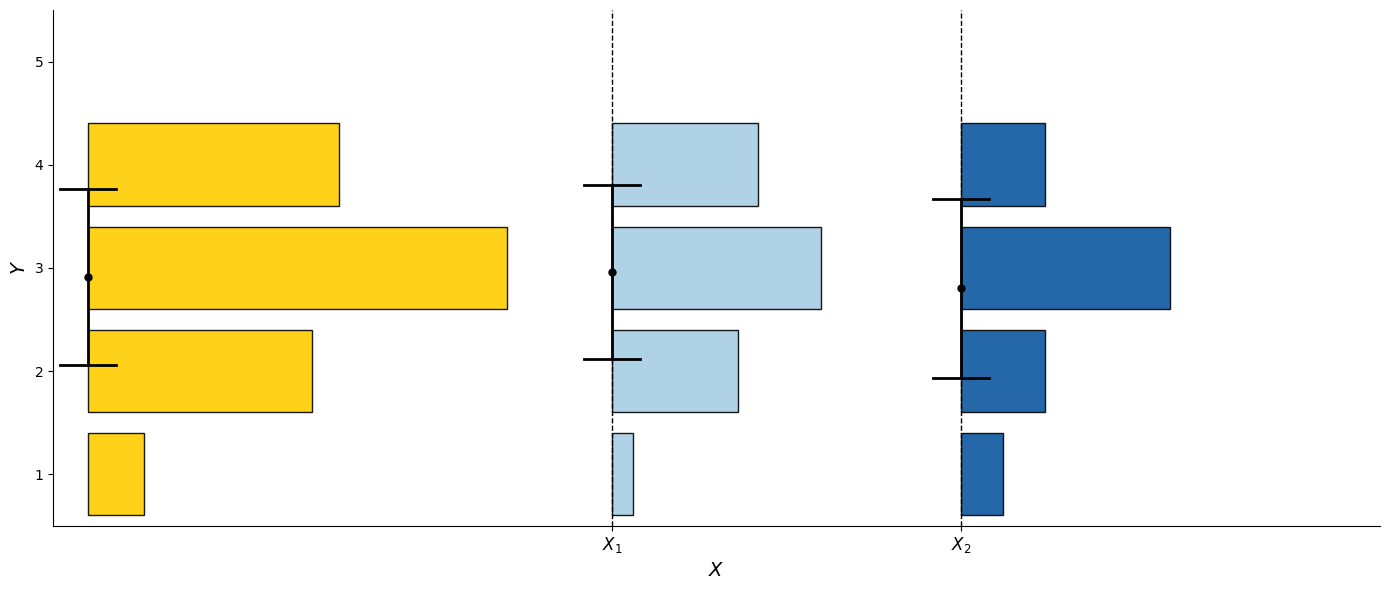

difficulty_1


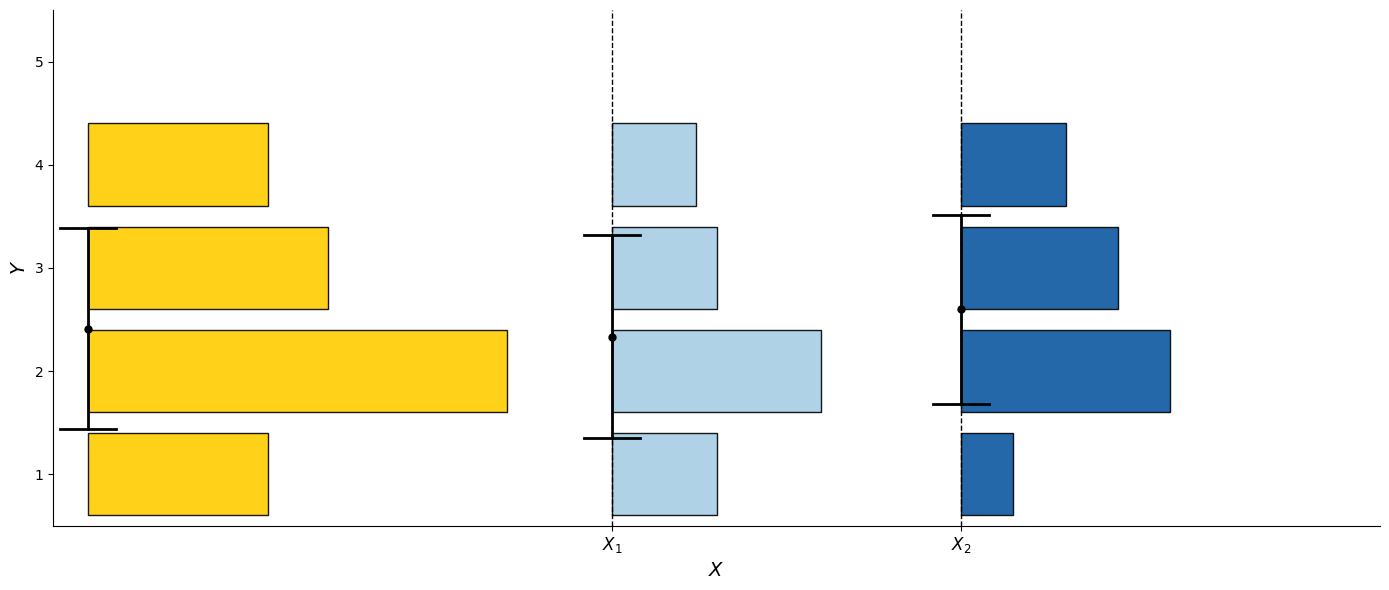

difficulty_2


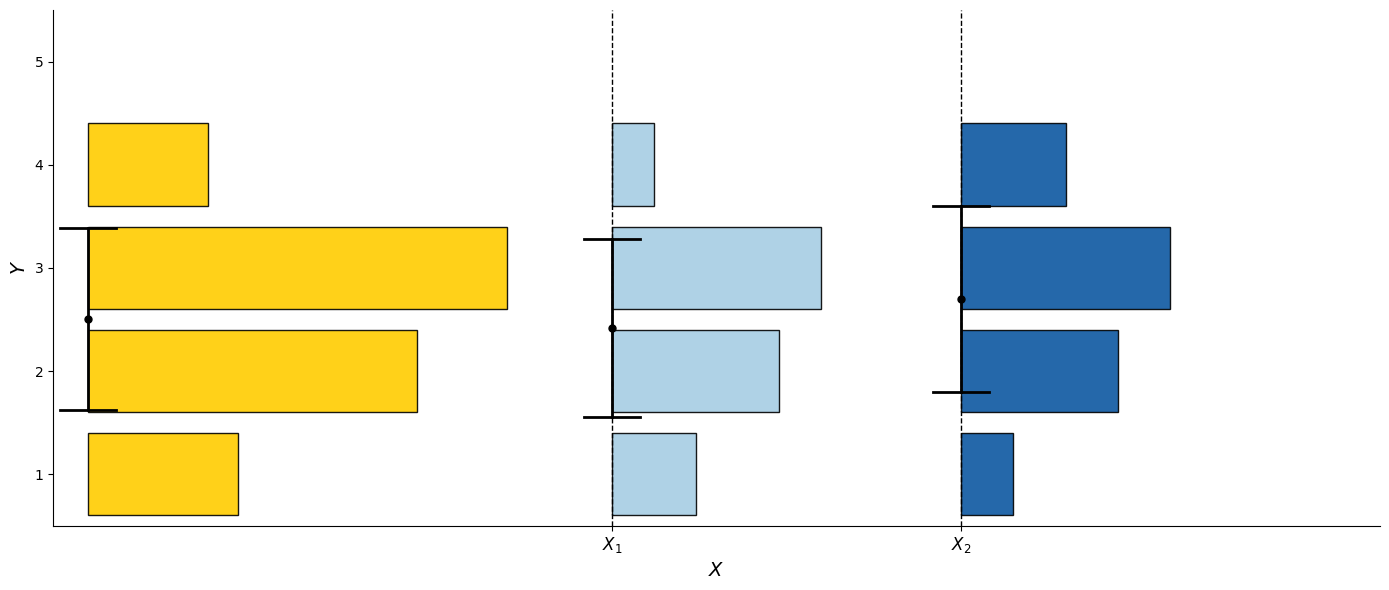

difficulty_3


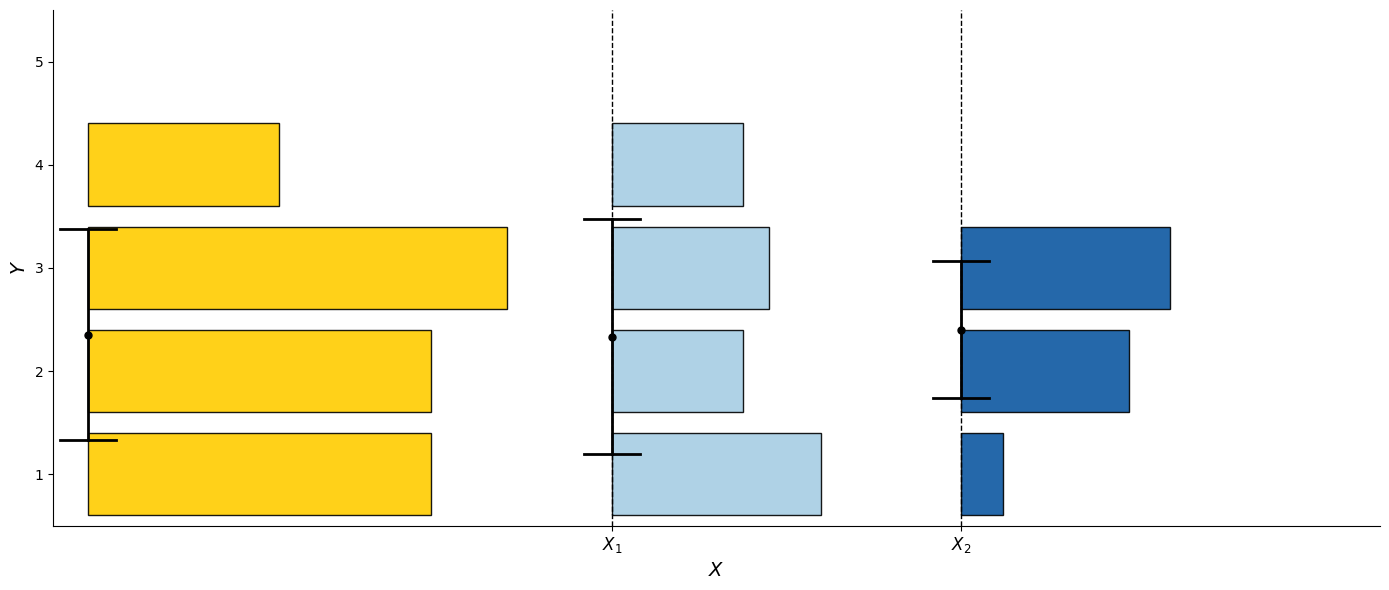

difficulty_4


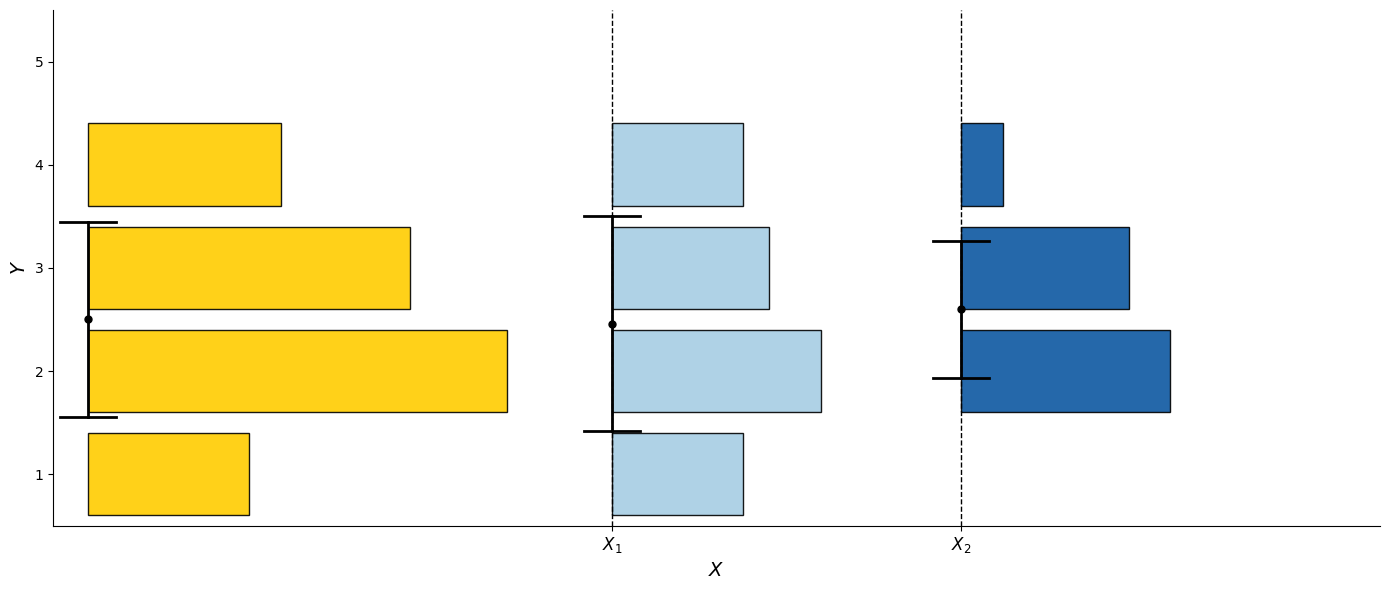

In [12]:
# For each Delay value
import fig.variance_plot as vpd
for col in task_one_difficulty_df_male.columns:
    if col in task_one_difficulty_df_female.columns:
        distributions=[
            task_one_difficulty_df_male[[col]], 
            task_one_difficulty_df_female[[col]]
        ],
        print(col)
        fig2, ax2 = vpd.variance_decomposition_plot([
            task_one_difficulty_df_male[[col]], 
            task_one_difficulty_df_female[[col]]
        ],
        y_max=5.5,
        variance_type='mse',
        show_dotted_lines=False,
        show_y_annotations=False,
        # figsize=(8, 6)
        bandwidth_adjust=0.5)
        plt.savefig(f'out_csv/difficulty MF/{col}_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        

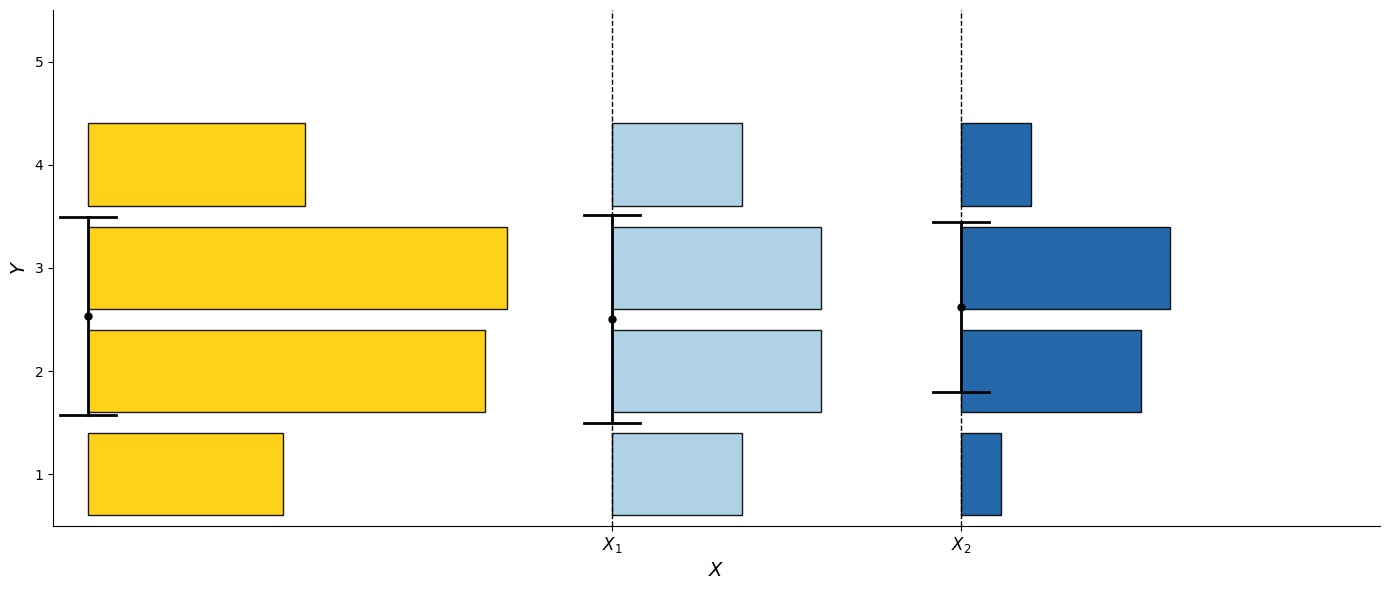

In [13]:
# For the overall variances from total
import fig.variance_plot as vpd
# for col in task_one_difficulty_df_male.columns:
#     if col in task_one_difficulty_df_female.columns:
# distributions=[
#     task_one_difficulty_df_male[[col]], 
#     task_one_difficulty_df_female[[col]]
# ],

fig2, ax2 = vpd.variance_decomposition_plot([
    task_one_difficulty_df_male, 
    task_one_difficulty_df_female
],
y_max=5.5,
variance_type='mse',
show_dotted_lines=False,
show_y_annotations=False,
# figsize=(8, 6)
bandwidth_adjust=0.5)
plt.savefig(f'out_csv/difficulty MF/{col}_plot.png', dpi=300, bbox_inches='tight')
plt.show()
        

difficulty_0


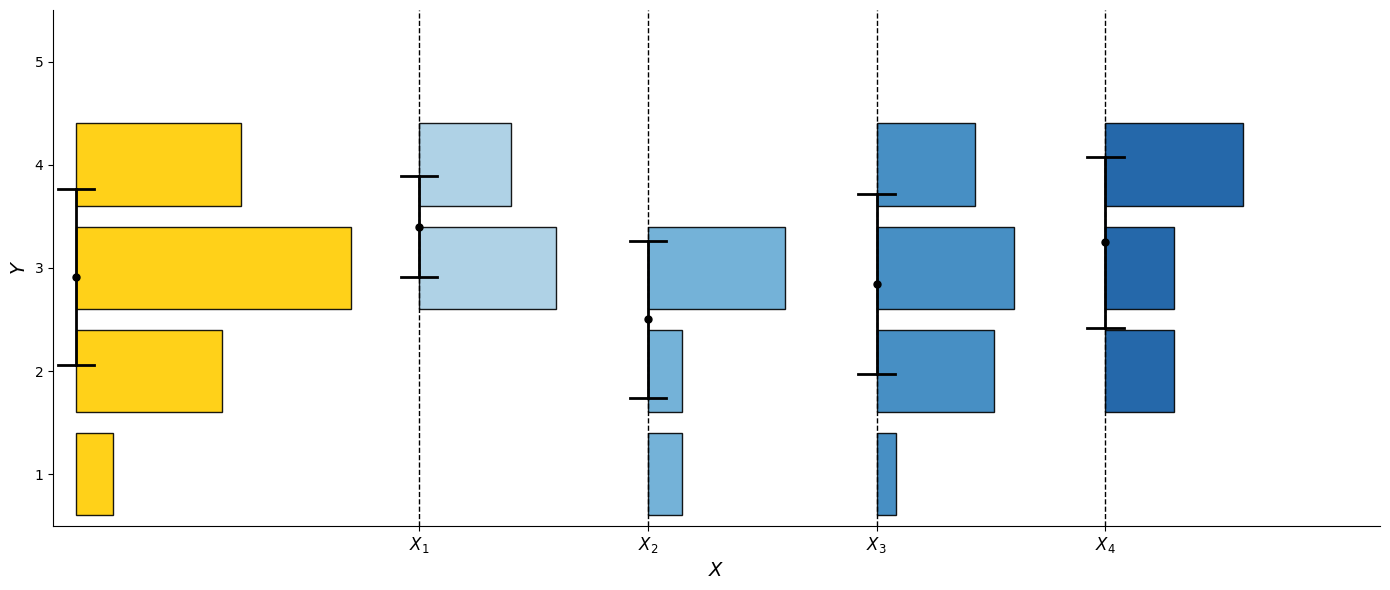

difficulty_1


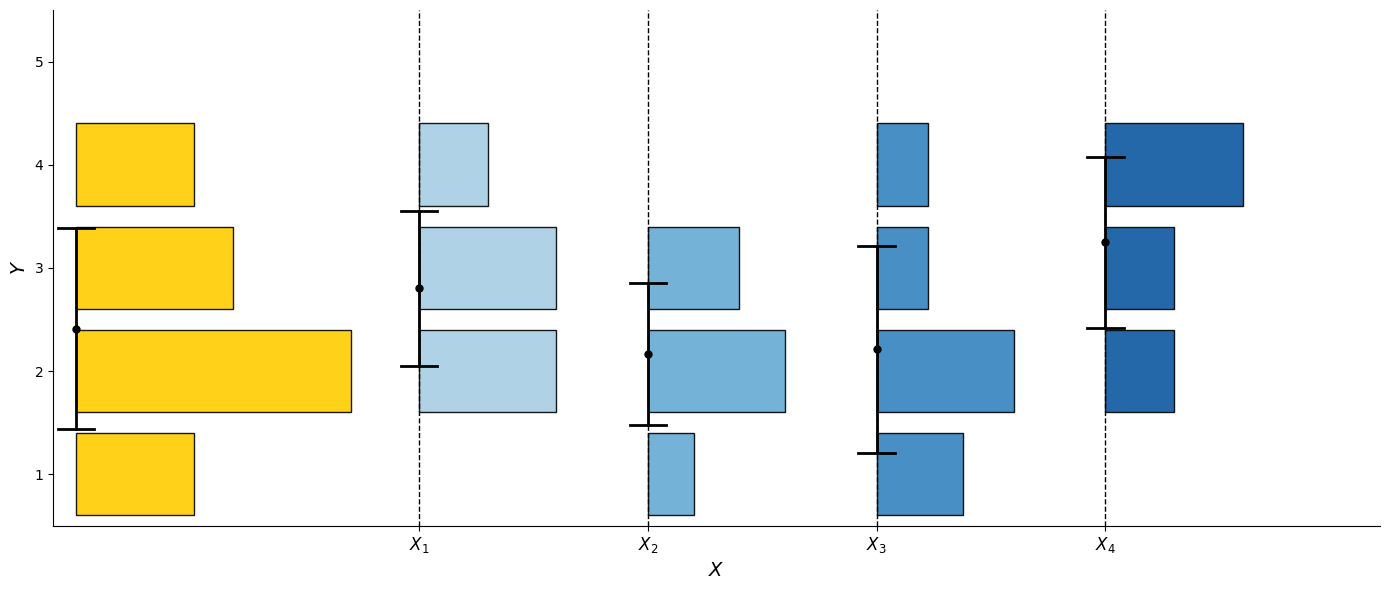

difficulty_2


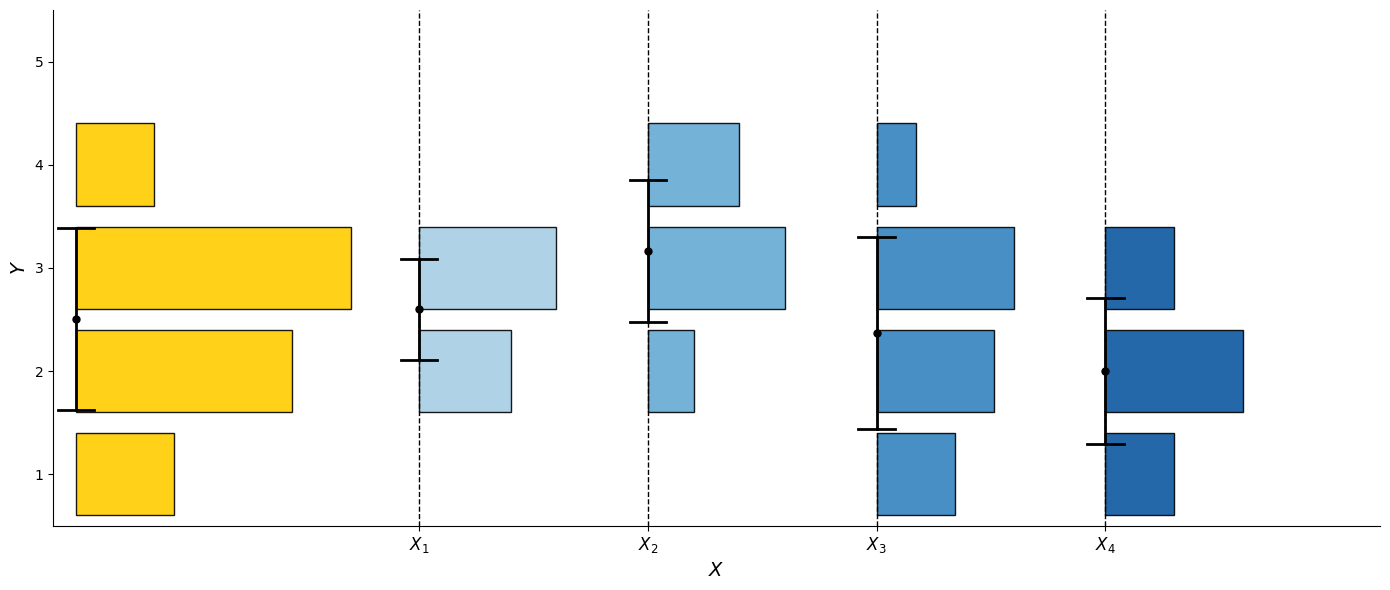

difficulty_3


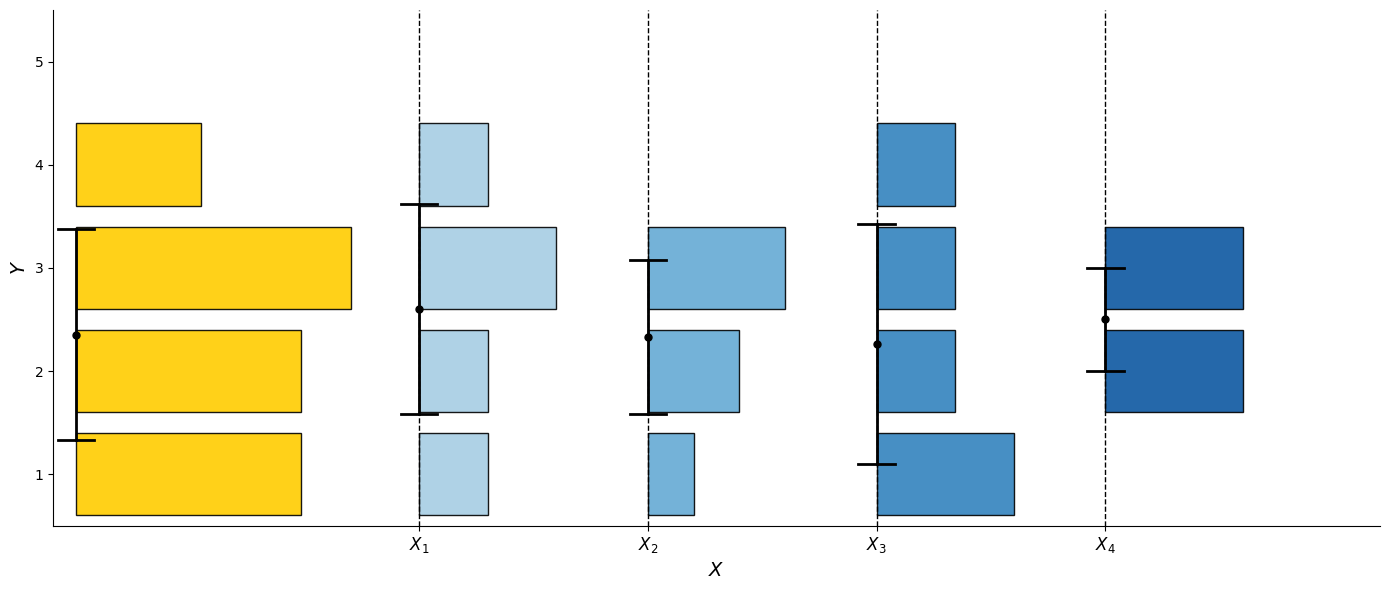

difficulty_4


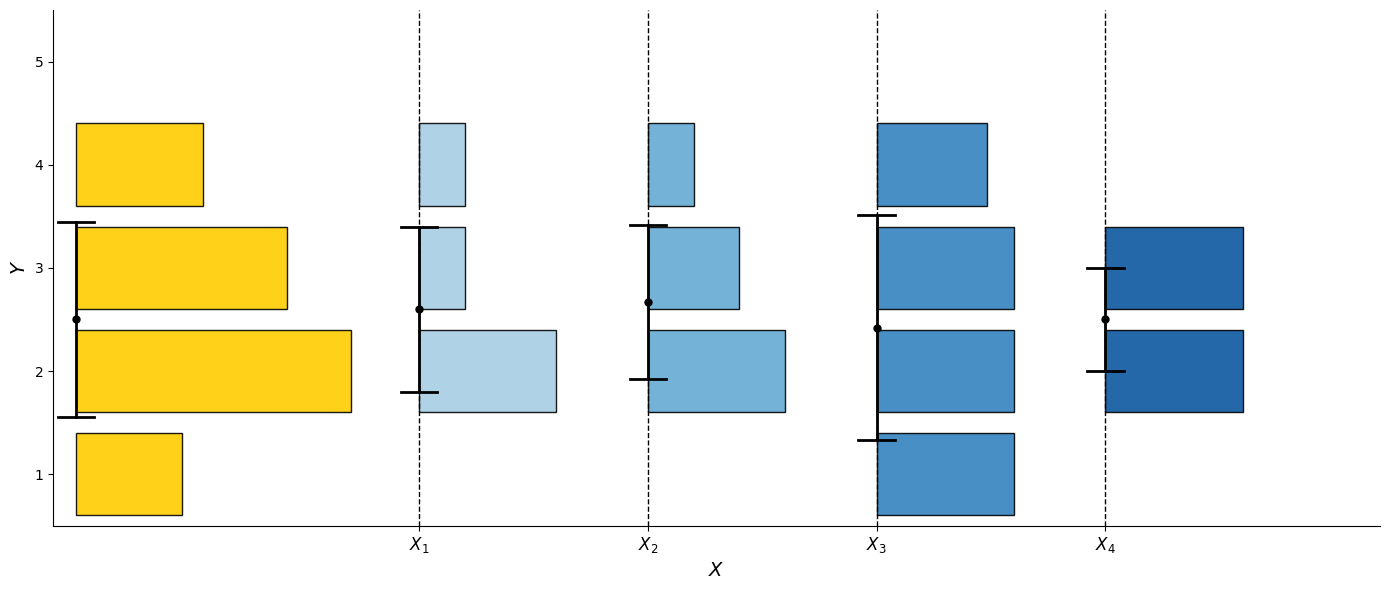

In [14]:
import fig.variance_plot as vpd
for col in task_one_difficulty_M_A24.columns:
    if col in task_one_difficulty_F_A24.columns:
        if col in task_one_difficulty_M_U24.columns:
            if col in task_one_difficulty_F_U24.columns:
                # Calculate statistics for this column pair
                # stats_df = alt_vp.calculate_statistics(
                distributions=[
                    task_one_difficulty_M_A24[[col]], 
                    task_one_difficulty_F_A24[[col]],
                    task_one_difficulty_M_U24[[col]], 
                    task_one_difficulty_F_U24[[col]]
                ]
                # distributions=[
                #     task_one_difficulty_df_male[[col]], 
                #     task_one_difficulty_df_female[[col]]
                # ],
                print(col)
                fig2, ax2 = vpd.variance_decomposition_plot(distributions,
                y_max=5.5,
                variance_type='mse',
                show_dotted_lines=False,
                show_y_annotations=False,
                # figsize=(8, 6)
                bandwidth_adjust=0.5)
                plt.savefig(f'out_csv/difficulty MF-AGE/{col}_plot.png', dpi=300, bbox_inches='tight')
                plt.show()
